In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.tail(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
3748,21-03-2024,1035.599976,9903738,6715.750000,1806092,255.699997,10121220,149.949997,6212045,1445.750000,...,1772.150024,3783681,121.050003,38099730,744.299988,15161161,450.250000,18429233,841.599976,987716
3749,22-03-2024,1033.300049,9891194,6760.899902,1125238,259.799988,11402546,149.600006,8409218,1442.849976,...,1776.400024,7061283,122.750000,35001868,746.700012,15535921,460.100006,12531582,861.500000,1618543
3750,26-03-2024,1040.550049,9656767,6910.100098,1850321,261.549988,8259347,149.800003,7742995,1425.400024,...,1753.699951,5303630,123.949997,30860596,740.049988,14678342,461.399994,10475524,858.250000,1391794
3751,27-03-2024,1052.849976,17027308,7022.750000,1551275,258.750000,19196992,149.800003,20853016,1440.699951,...,1775.599976,8231130,122.750000,42673023,733.299988,30088789,445.600006,28138339,840.200012,1344329
3752,28-03-2024,1047.199951,10235318,7245.250000,3574518,264.049988,11966752,150.199997,7208707,1447.900024,...,1785.500000,6630072,124.400002,29453142,752.349976,21705116,451.000000,12637899,849.349976,5261416


In [3]:
feature_columns = [ 'SBI', 'SBIVOL']
target_column = ['SBI']
features = df[feature_columns]
target = df[target_column].shift(-1)

new_data1 = 758.30
target.iloc[-1, 0] = new_data1

target.tail(5)

,SBI
3748,746.700012
3749,740.049988
3750,733.299988
3751,752.349976
3752,758.300000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

n_steps = 5  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_sbi1_0.9809.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R2: 0.9809
MAPE: 0.0174
RMSE: 11.9973
RMSE_normalizeddata: 0.0172
MAE_normalizeddata: 0.0130
MAE: 9.1097


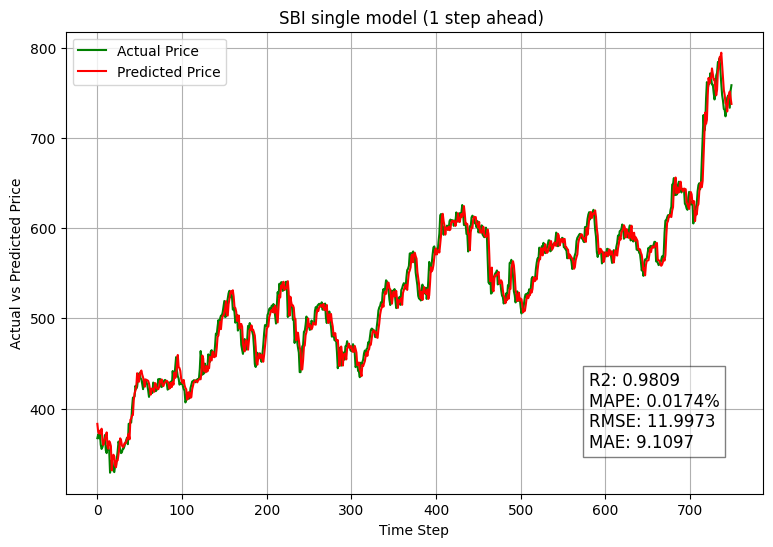

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('SBI single model (1 step ahead) ')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('sbi_1sa-1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R2: 0.9745
MAPE: 0.0276
RMSE: 8.6623
RMSE_normalizeddata: 0.0124
MAE_normalizeddata: 0.0093
MAE: 6.4956


In [65]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0113 - val_loss: 0.0128
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.4922e-04 - val_loss: 0.0025
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.6072e-04 - val_loss: 0.0023
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.3042e-04 - val_loss: 0.0015
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.4516e-04 - val_loss: 0.0015
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.4931e-04 - val_loss: 0.0012
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.5331e-04 - val_loss: 0.0012
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1481e-04 - val_loss: 0.0011
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.3023e-04 - val_loss: 0.0010
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1674e-04 - val_loss: 0.0024
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0648e-04 - val_loss: 0.0023
Epoch 12/200

In [66]:
model_lstm.save('model_lstm_bajajfin1h_1.keras')

In [67]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0079 - val_loss: 0.0028
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.6540e-04 - val_loss: 0.0015
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.5815e-04 - val_loss: 0.0023
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1190e-04 - val_loss: 0.0013
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.3825e-04 - val_loss: 0.0021
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.4675e-04 - val_loss: 0.0030
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.2753e-04 - val_loss: 0.0016
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1506e-04 - val_loss: 0.0011
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.7030e-04 - val_loss: 0.0011
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.0807e-04 - val_loss: 0.0010
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.0233e-04 - val_loss: 0.0024
Epoch 12/200

In [68]:
model_lstm.save('model_lstm_bajajfin1h_2.keras')

In [69]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0085 - val_loss: 0.0073
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.3616e-04 - val_loss: 0.0015
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.7585e-04 - val_loss: 0.0027
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.1471e-04 - val_loss: 0.0026
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.2183e-04 - val_loss: 0.0016
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.0143e-04 - val_loss: 0.0023
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.5071e-04 - val_loss: 0.0017
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1220e-04 - val_loss: 0.0017
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1241e-04 - val_loss: 0.0025
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1301e-04 - val_loss: 0.0015
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.0787e-04 - val_loss: 0.0010
Epoch 12/200

In [70]:
model_lstm.save('model_lstm_bajajfin1h_3.keras')

In [71]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.3549e-04 - val_loss: 0.0019
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.1387e-04 - val_loss: 0.0014
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.2282e-04 - val_loss: 0.0014
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.2940e-04 - val_loss: 0.0020
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.4283e-04 - val_loss: 0.0012
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1903e-04 - val_loss: 0.0017
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.0986e-04 - val_loss: 0.0011
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.0309e-04 - val_loss: 0.0018
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.3712e-04 - val_loss: 9.8886e-04
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1549e-04 - val_loss: 0.0013
Epoch 12

In [72]:
model_lstm.save('model_lstm_bajajfin1h_4.keras')

In [73]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0074 - val_loss: 0.0056
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.4233e-04 - val_loss: 0.0034
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.2015e-04 - val_loss: 0.0028
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.4480e-04 - val_loss: 0.0027
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1402e-04 - val_loss: 0.0013
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.5351e-04 - val_loss: 0.0017
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.5096e-04 - val_loss: 0.0016
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1960e-04 - val_loss: 0.0021
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.1947e-04 - val_loss: 0.0019
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.1497e-04 - val_loss: 0.0018
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.2842e-04 - val_loss: 0.0011
Epoch 12/200

In [74]:
model_lstm.save('model_lstm_bajajfin1h_5.keras')

In [75]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 1.3106e-04 - val_loss: 0.0019
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.2878e-04 - val_loss: 0.0020
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.0946e-04 - val_loss: 0.0015
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.1176e-04 - val_loss: 0.0026
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.1396e-04 - val_loss: 0.0014
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 1.1370e-04 - val_loss: 0.0034
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 1.1539e-04 - val_loss: 0.0027
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.2076e-04 - val_loss: 0.0014
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.1591e-04 - val_loss: 0.0016
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.1021e-04 - val_loss: 0.0023
Epoch 12/20

In [76]:
model_lstm.save('model_lstm_bajajfin1h_6.keras')

In [77]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 0.0099 - val_loss: 0.0061
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.5782e-04 - val_loss: 0.0020
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.3939e-04 - val_loss: 0.0027
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.1812e-04 - val_loss: 0.0014
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.2146e-04 - val_loss: 0.0015
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.1778e-04 - val_loss: 0.0012
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.1166e-04 - val_loss: 0.0011
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.4546e-04 - val_loss: 0.0013
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.0635e-04 - val_loss: 0.0035
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.0544e-04 - val_loss: 0.0035
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.1407e-04 - val_loss: 0.0014
Epoch 12/20

In [78]:
model_lstm.save('model_lstm_bajajfin1h_7.keras')

In [79]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - loss: 0.0096 - val_loss: 0.0125
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 1.4556e-04 - val_loss: 0.0033
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.3685e-04 - val_loss: 0.0026
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 1.1382e-04 - val_loss: 0.0015
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.3676e-04 - val_loss: 0.0013
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.1494e-04 - val_loss: 0.0018
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 1.2959e-04 - val_loss: 0.0014
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 1.4103e-04 - val_loss: 0.0015
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 9.5814e-05 - val_loss: 0.0012
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 1.1676e-04 - val_loss: 0.0016
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.1111e-04 - val_loss: 0.0016
Epoch 12/20

In [80]:
model_lstm.save('model_lstm_bajajfin1h_8.keras')

In [81]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.0107 - val_loss: 0.0038
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.5762e-04 - val_loss: 0.0033
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.4781e-04 - val_loss: 0.0028
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.4757e-04 - val_loss: 0.0023
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.2376e-04 - val_loss: 0.0039
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.4788e-04 - val_loss: 0.0012
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.0393e-04 - val_loss: 0.0017
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.2015e-04 - val_loss: 0.0020
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.5572e-04 - val_loss: 0.0014
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.3506e-04 - val_loss: 0.0011
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.4694e-04 - val_loss: 0.0010
Epoch 12/20

In [82]:
model_lstm.save('model_lstm_bajajfin1h_9.keras')

In [83]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 0.0119 - val_loss: 0.0097
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.4661e-04 - val_loss: 0.0089
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.5139e-04 - val_loss: 0.0025
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.2675e-04 - val_loss: 0.0025
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.2710e-04 - val_loss: 0.0040
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.2152e-04 - val_loss: 0.0036
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.5028e-04 - val_loss: 0.0025
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.3884e-04 - val_loss: 0.0027
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.3061e-04 - val_loss: 0.0013
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.2055e-04 - val_loss: 0.0013
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.1244e-04 - val_loss: 0.0011
Epoch 12/20

In [84]:
model_lstm.save('model_lstm_bajajfin1h_10.keras')